# Wine Reviews

This dataset comes from Kaggle and contains many reviews of different types of wines. This is my first project back from a short hiatus from data science projects so it'll be a good exercise to get back in the swing of things for EDA and possibly gives an opportunity for some predictive modeling! Side benefit here is discretly learning more about wine to impress my wife and friends.

I'll be commenting my train of thought in this notebook to articulate why I run certain processes while going through this dataset. For this first project I'll be going through just the first dataset presented. At a later time or if we feel we need more training data, we'll start to include the other datasets provided.

In [174]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

In [175]:
# Import datasets
review_df1 = pd.read_csv('dataset/winemag-data_first150k.csv')
review_df2 = pd.read_csv('dataset/winemag-data-130k-v2.csv')

data = json.load(open('dataset/winemag-data-130k-v2.json'))
review_df3 = pd.DataFrame(data)

## EDA
Let's clean and look at what the dataset looks like.

#### Dataset 1
We'll first see how clean the data is then format of the data to analyze later if necessary.

In [188]:
print('Number of reviews:')
print(review_df1.shape[0])
print('')

print('Column names:')
for col in review_df1.columns:
    print(col)
print('')

print('Count of NULLs by column:')
print(review_df1.isnull().sum())
print('')

print('Column data types:')
print(review_df1.dtypes)
print('')

print('Count of dupes')
temp = review_df1.drop(review_df1.columns[0], axis=1)
print(temp[temp.duplicated()].shape[0])

Number of reviews:
150930

Column names:
Unnamed: 0
country
description
designation
points
price
province
region_1
region_2
variety
winery

Count of NULLs by column:
Unnamed: 0         0
country            5
description        0
designation    45735
points             0
price          13695
province           5
region_1       25060
region_2       89977
variety            0
winery             0
dtype: int64

Column data types:
Unnamed: 0       int64
country         object
description     object
designation     object
points           int64
price          float64
province        object
region_1        object
region_2        object
variety         object
winery          object
dtype: object

Count of dupes
53079


In [6]:
review_df1.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


The dataset itself looks to have a description and several attributes on location. There's 2 potential target vectors that would be interesting to try to build models after which are points and price. Points is the amount of points the reviewer gave for the particular wine and is based from 0-100- 100 being the best score. 

The description column is interesting here as we'll have some opportunity to run NLP and sentiment analysis as well.

Nothing seems too out of the ordinary with the dataset. From what I can see above it looks relatively clean. The only cleaning I'd like to do is fill in the Nan values in the categorical columns with 'None' to provide a label and get rid of the dupes. From the count of nulls above it looks to be just 4 columns. There's quite a bit of Nans for price, so we'll need to be aware of that.

We'll rename the first reviews dataset to df for convenience.

In [195]:
df[df.duplicated()].sort_values('description').shape

(53079, 10)

In [200]:
df = review_df1.drop(review_df1.columns[0], axis=1)

cat_columns = ['country', 'designation', 'region_1', 'region_2']

df[cat_columns] = df[cat_columns].fillna('None', axis=1)

df = df[~df.duplicated()]

Now that that's done, let's do some explaratory analysis on the data.

In [201]:
df.describe()[['points', 'price']]

,points,price
count,97851.000000,89131.000000
mean,87.956730,33.658783
std,3.218138,37.670180
min,80.000000,4.000000
25%,86.000000,16.000000
50%,88.000000,25.000000
75%,90.000000,40.000000
max,100.000000,2300.000000


Average score of 87.95 for all wines with the average price being $33.66. Standard deviation is interesting as there isn't much of a variance for points, but seems irreguarly high for price- probably due to outliers. We'll seperate out the outliers for price and do more EDA on the general population of reviews.

In [203]:
general_df = df[df['price']<=100]
premium_df = df[df['price']>100]

general_count = general_df.shape[0]
premium_count = premium_df.shape[0]
total_count = premium_count + general_count

print('% over $100: {0:.2%}'.format(premium_count / total_count))
print('% equal to or under $100: {0:.2%}'.format(general_count / total_count))
print('')
print('Number of wines under or equal to $100: {}'.format(general_count))
print('Number of wines over $100: {}'.format(premium_count))

% over $100: 2.62%
% equal to or under $100: 97.38%

Number of wines under or equal to $100: 86794
Number of wines over $100: 2337


$100 seems like an appropriate differentiation between what we will call 'general' wines and 'premium' wines.

Text(0, 0.5, 'Count')

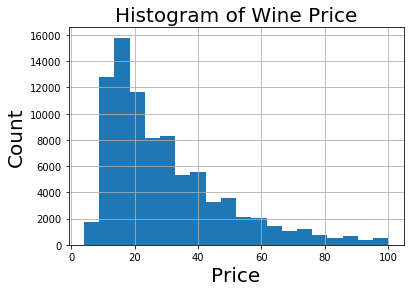

In [204]:
general_df['price'].plot.hist(grid=True, bins=20)
plt.title('Histogram of Wine Price', fontsize=20)
plt.xlabel('Price', fontsize=20)
plt.ylabel('Count', fontsize=20)

Even amongst the general wines it looks like the majority is just under 60 dollars and it quickly tapers off to the 100 dollar mark.

Text(0, 0.5, 'Count')

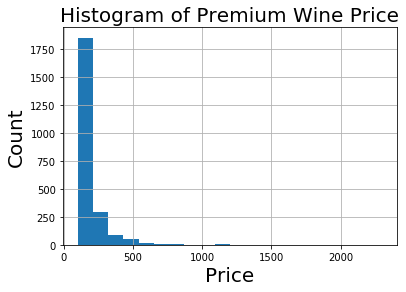

In [205]:
premium_df['price'].plot.hist(grid=True, bins=20)
plt.title('Histogram of Premium Wine Price', fontsize=20)
plt.xlabel('Price', fontsize=20)
plt.ylabel('Count', fontsize=20)

For the premium wines it looks like the large majority is around 300 dollars and quickly tapers to almost nothing at a peak of 2300 dollars.

Let's focus on the general wines for now and do some analysis on countries and regions.

In [221]:
t = general_df.groupby('country').count()[['description']].sort_values('description', ascending=False)
t['Percent of Total'] = t['description'] / t.description.sum()
t.columns = ['Count', 'Percent of Total']
t

,Count,Percent of Total
country,,
US,39704,0.457451
Italy,11723,0.135067
France,9454,0.108925
Spain,5198,0.059889
Chile,3679,0.042388
Argentina,3366,0.038781
Australia,3002,0.034588
Portugal,2669,0.030751
New Zealand,1743,0.020082


Text(0.5, 1.0, 'Price Spread')

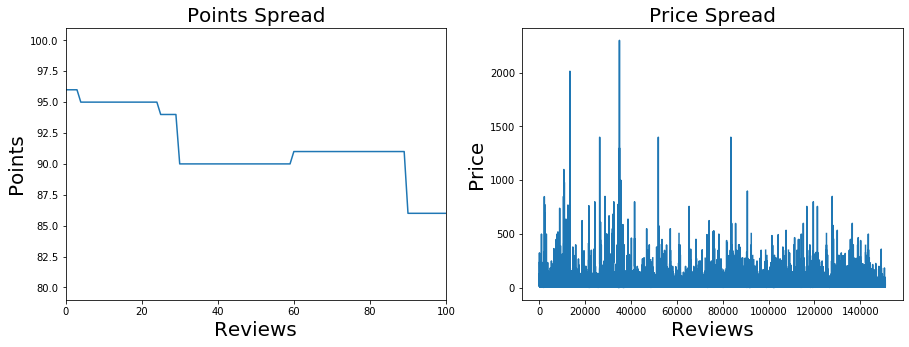

In [127]:
f = plt.figure(figsize=(15, 5))

ax1 = f.add_subplot(121)
ax1.plot(df['points'])
ax1.set_xlim([0, 100])
ax1.set_ylabel('Points', fontsize=20)
ax1.set_xlabel('Reviews', fontsize=20)
ax1.set_title('Points Spread', fontsize=20)

ax2 = f.add_subplot(122)
ax2.plot(df['price'])
ax2.set_ylabel('Price', fontsize=20)
ax2.set_xlabel('Reviews', fontsize=20)
ax2.set_title('Price Spread', fontsize=20)